In [41]:
import requests
import geopandas as gpd
import folium
from plotnine import ggplot, geom_polygon, aes, coord_equal, theme_void, theme
from shapely.geometry import Polygon, LineString, MultiPolygon
import json
import pandas as pd

### Query Open Street Map's Overpass API for golf course polygons in San Luis Obispo County

In [42]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area[name="San Luis Obispo County"]["admin_level"="6"]->.searchArea;
(
  nwr["leisure"="golf_course"](area.searchArea);
);
out body;
>;
out skel qt;
"""
# nwr means nodes ways or relations
# nodes are lat long points
# ways and relations are lines and/or polygons that represent the golf course

In [43]:
response = requests.get(overpass_url, params={"data": overpass_query})
response.status_code

200

In [44]:
slo_data = response.json()
# print(json.dumps(slo_data, indent=4))

In [45]:
# count how many relations and ways we have
relation_count = 0
way_count = 0
node_count = 0

for element in slo_data["elements"]:
    if element["type"] == "relation":
        relation_count += 1
    elif element["type"] == "way":
        way_count += 1
    elif element["type"] == "node":
        node_count += 1

print(f"Relations: {relation_count}")
print(f"Ways: {way_count}")
print(f"Nodes: {node_count}")

Relations: 5
Ways: 37
Nodes: 2041


### Plot relations and ways

In [46]:
ways = [element for element in slo_data["elements"] if element["type"] == "way"]
relations = [
    element for element in slo_data["elements"] if element["type"] == "relation"
]
nodes = {
    element["id"]: element
    for element in slo_data["elements"]
    if element["type"] == "node"
}

In [47]:
def create_geometry(element, nodes):
    coords = [
        (nodes[node_id]["lon"], nodes[node_id]["lat"]) for node_id in element["nodes"]
    ]
    return (
        Polygon(coords)
        if element["nodes"][0] == element["nodes"][-1]
        else LineString(coords)
    )

In [48]:
way_features = []
for way in ways:
    if "nodes" in way:
        geometry = create_geometry(way, nodes)
        tags = way.get("tags", {})
        feature = {
            "type": "Feature",
            "geometry": geometry.__geo_interface__,
            "properties": {
                "type": way["type"],
                "id": way["id"],
                "name": tags.get("name", "NA"),
            },
        }
        way_features.append(feature)
way_features[:1]

[{'type': 'Feature',
  'geometry': {'type': 'Polygon',
   'coordinates': (((-120.8537094, 35.3157637),
     (-120.8536135, 35.3151746),
     (-120.8535925, 35.3150151),
     (-120.8536386, 35.3149913),
     (-120.8550444, 35.3150047),
     (-120.8558366, 35.3150054),
     (-120.8566178, 35.3150026),
     (-120.8574396, 35.3150063),
     (-120.8582524, 35.3150117),
     (-120.8595017, 35.3150064),
     (-120.8595038, 35.314957),
     (-120.8595066, 35.3148906),
     (-120.8595752, 35.3148065),
     (-120.8595718, 35.3137947),
     (-120.8595756, 35.3126858),
     (-120.8607742, 35.3127667),
     (-120.860939, 35.312788),
     (-120.8608112, 35.3139016),
     (-120.8606911, 35.3144221),
     (-120.8606783, 35.3146127),
     (-120.8605239, 35.3152492),
     (-120.8604505, 35.3153239),
     (-120.8603065, 35.3158575),
     (-120.8566332, 35.3158796),
     (-120.8566332, 35.3163304),
     (-120.85579, 35.3163377),
     (-120.8557781, 35.3169479),
     (-120.8551852, 35.3168312),
     (-120.

In [49]:
relation_features = []
for relation in relations:
    outer_polygons = []
    inner_polygons = []
    for member in relation["members"]:
        if member["type"] == "way" and any(way["id"] == member["ref"] for way in ways):
            way = next(way for way in ways if way["id"] == member["ref"])
            if "nodes" in way:
                geometry = create_geometry(way, nodes)
                if member["role"] == "outer":
                    outer_polygons.append(geometry)
                elif member["role"] == "inner":
                    inner_polygons.append(geometry)
    if outer_polygons:
        multipolygon = Polygon(
            outer_polygons[0].exterior.coords,
            [inner.exterior.coords for inner in inner_polygons],
        )
        tags = relation.get("tags", {})
        feature = {
            "type": "Feature",
            "geometry": multipolygon.__geo_interface__,
            "properties": {
                "type": relation["type"],
                "id": relation["id"],
                "name": tags.get("name", "NA"),
            },
        }
        relation_features.append(feature)
relation_features[:1]

[{'type': 'Feature',
  'geometry': {'type': 'Polygon',
   'coordinates': (((-120.6631089, 35.6052301),
     (-120.6630889, 35.6047217),
     (-120.6636334, 35.6044571),
     (-120.663615, 35.6041513),
     (-120.6635191, 35.6041178),
     (-120.6634787, 35.6040549),
     (-120.6637974, 35.6039691),
     (-120.6645171, 35.6039854),
     (-120.6645381, 35.6042036),
     (-120.664571, 35.6042696),
     (-120.664757, 35.604356),
     (-120.664952, 35.604334),
     (-120.6651964, 35.6043692),
     (-120.6654253, 35.6043039),
     (-120.6659075, 35.6045316),
     (-120.6658974, 35.6047946),
     (-120.6656737, 35.6048885),
     (-120.6653989, 35.6046801),
     (-120.6653241, 35.6046234),
     (-120.6652968, 35.6046217),
     (-120.6644904, 35.6045715),
     (-120.664083, 35.604656),
     (-120.663613, 35.6046849),
     (-120.6636602, 35.6049404),
     (-120.6639524, 35.6051225),
     (-120.6642011, 35.6051667),
     (-120.6641332, 35.6055648),
     (-120.664191, 35.605782),
     (-120.664620

In [50]:
# make 1 geojson
geojson = {"type": "FeatureCollection", "features": way_features + relation_features}

In [51]:
# plot and manually inspect
m = folium.Map(location=[35.3126858, -120.8595756], zoom_start=11)

folium.GeoJson(
    geojson,
    style_function=lambda x: {
        "color": "blue" if x["properties"]["type"] == "way" else "red",
        "weight": 2,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["type", "id", "name"],
        aliases=["Type", "ID", "Name"],
        labels=True,
        localize=True,
    ),
).add_to(m)

m

See the interactive map with [nbviewer](https://nbviewer.org/github/maggie-reiter/turfgrass-maps/blob/main/SLO%20County%20golf%20courses/slo_county_golf.ipynb)

### Load and plot SLO County outline

In [52]:
# from https://opendata.slocounty.ca.gov/
county_data = gpd.read_file("./County_Boundary.geojson")

In [53]:
m = folium.Map(location=[35.3126858, -120.8595756], zoom_start=10)

folium.GeoJson(county_data).add_to(m)

m

See the interactive map with [nbviewer](https://nbviewer.org/github/maggie-reiter/turfgrass-maps/blob/main/SLO%20County%20golf%20courses/slo_county_golf.ipynb)

### Map golf courses onto county polygon

In [54]:
geojson_str = json.dumps(geojson)
golf_courses_gdf = gpd.GeoDataFrame.from_features(json.loads(geojson_str)["features"])

In [55]:
golf_courses_gdf.head()

,geometry,type,id,name
0,"POLYGON ((-120.85371 35.31576, -120.85361 35.3...",way,43701467,Sea Pines Golf Course
1,"POLYGON ((-120.84372 35.35413, -120.84132 35.3...",way,43701484,Morro Bay Golf Course
2,"POLYGON ((-120.69949 35.25844, -120.69952 35.2...",way,43701873,Laguna Lake Golf Course
3,"POLYGON ((-120.63028 35.21538, -120.63012 35.2...",way,43701987,San Luis Obispo Country Club
4,"POLYGON ((-120.64370 35.47555, -120.64620 35.4...",way,43702330,Chalk Mountain Golf Course


In [56]:
# no crs, manually set to EPSG:4326 which is what the Overpass API uses
golf_courses_gdf.set_crs(epsg=4326, inplace=True)
golf_courses_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [57]:
county_data.head()

,OBJECTID,NAME,ACRES,ShapeSTArea,ShapeSTLength,geometry
0,1,San Luis Obispo,2124248.332,9.253016e+10,2.100405e+06,"POLYGON ((-120.43059 34.98344, -120.42934 34.9..."


In [58]:
county_data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [59]:
# set crs to utm projection for improved visualization
county_data = county_data.to_crs("EPSG:32610")
golf_courses_gdf = golf_courses_gdf.to_crs("EPSG:32610")

In [60]:
# convert to df for plotnine ggplot
def geodf_to_df(gdf):
    df_list = []
    for idx, row in gdf.iterrows():
        geom = row.geometry
        if isinstance(geom, (Polygon, MultiPolygon)):
            if isinstance(geom, Polygon):
                geom = [geom]
            for poly in geom:
                xs, ys = poly.exterior.xy
                df_list.append(pd.DataFrame({"x": xs, "y": ys, "group": idx}))
    return pd.concat(df_list, ignore_index=True)


county_df = geodf_to_df(county_data)
golf_courses_df = geodf_to_df(golf_courses_gdf)

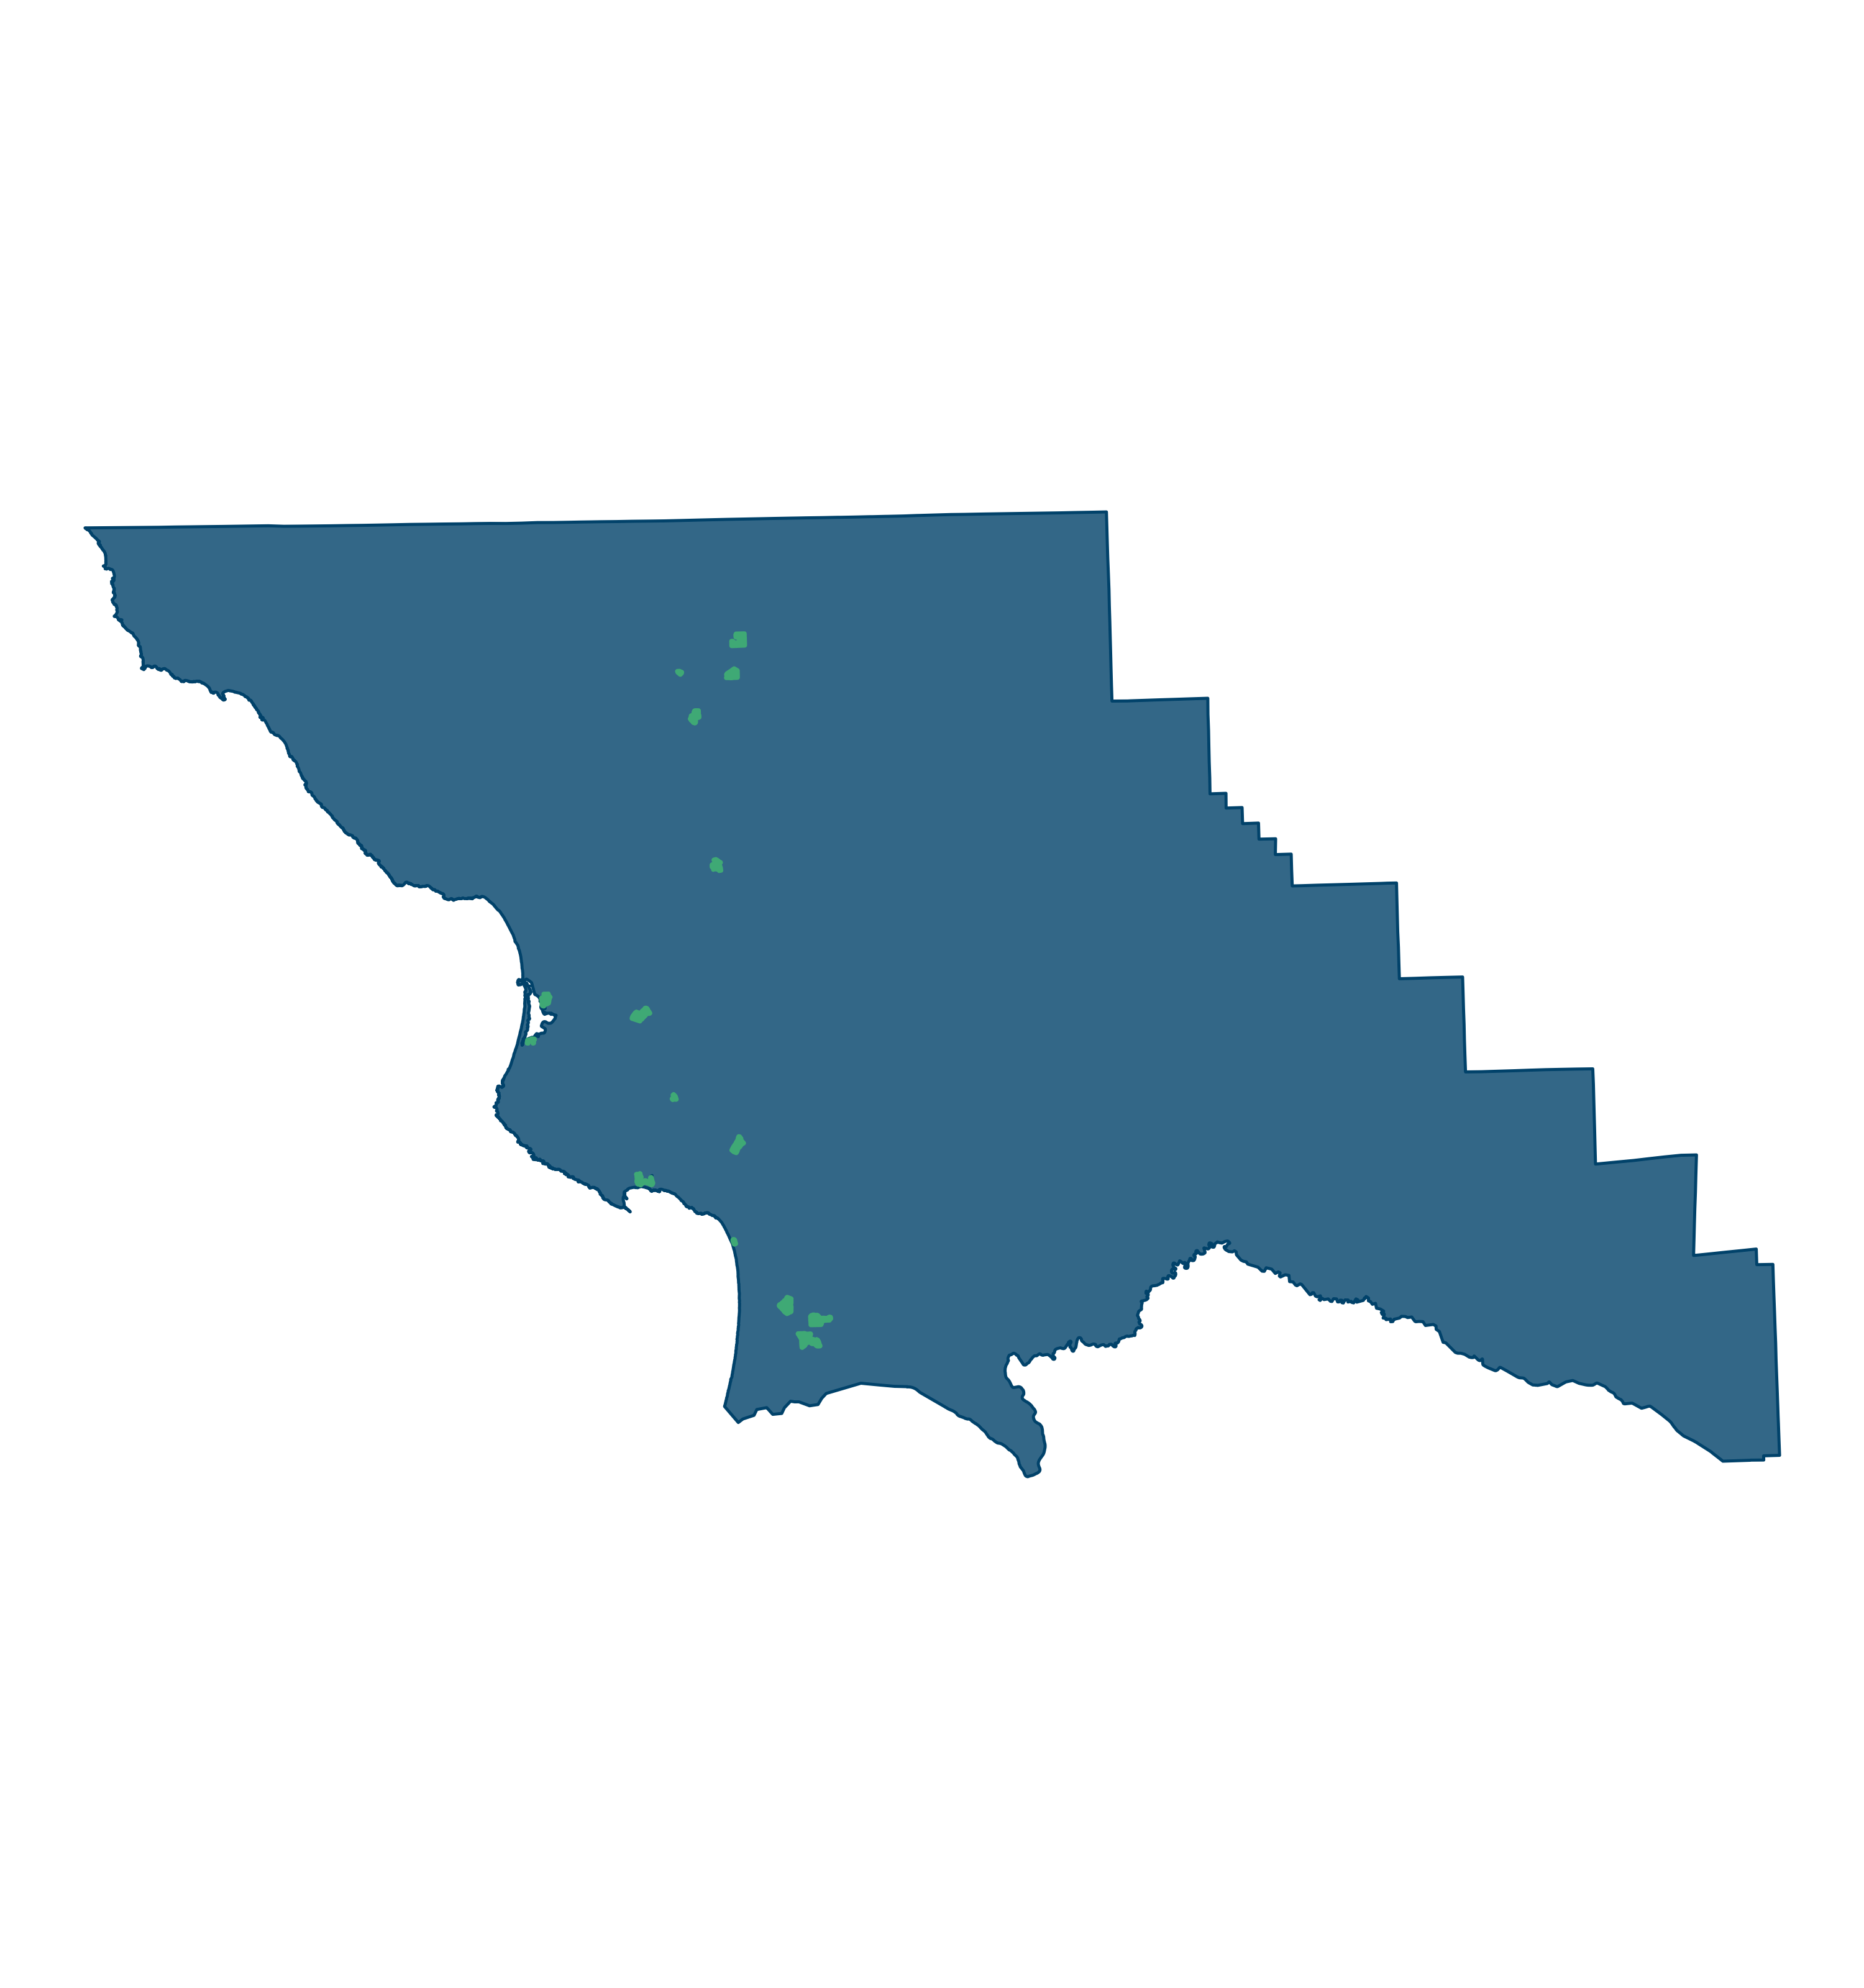

In [61]:
# give golf courses a big outline to make them stand out more
p = (
    ggplot()
    + geom_polygon(
        data=county_df,
        mapping=aes(x="x", y="y", group="group"),
        fill="#01426A",
        color="#01426A",
        alpha=0.8,
        size=1,
    )
    + geom_polygon(
        data=golf_courses_df,
        mapping=aes(x="x", y="y", group="group"),
        fill="#3FA975",
        color="#3FA975",
        size=1.5,
    )
    + coord_equal()
    + theme_void()
    + theme(figure_size=(15, 16))
)

p.show()